*This notebook fits and save final models (for 5 types of models and 4 subsetting options), as well as Validation R2 scores*

*Section 5 visualizes some of these results*

# Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import permutation_test_score

from mpl_toolkits.basemap import Basemap
import hazelbean as hb

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import pickle

## Sherlock version

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import xgboost as xgb
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import permutation_test_score

#from mpl_toolkits.basemap import Basemap
import hazelbean as hb

#import seaborn as sns
#import matplotlib.pyplot as plt

#pd.set_option('display.max_columns', 500) pd.set_option('display.max_rows', 500)
import pickle

# Load dataset

## Original way: train/test randomly

In [2]:
def load_data(subset=True):
    ''' subset takes values of : True/float/False
            True : (sampling of 2% by default)
            Float : Fraction to sample (e.g 0.10 for 10%)
            False : returns df, X_validation, y_validation
    '''
    
    #L.info('Loading data')
    crop_types_df = pd.read_csv('../ipbes_invest_crop_yield_project/intermediate/aggregate_crops_by_type/aggregated_crop_data.csv')
    df_land = pd.read_csv('../ipbes_invest_crop_yield_project/intermediate/create_baseline_regression_data/baseline_regression_data.csv')
    #L.info('Data loaded')

    df = crop_types_df.merge(df_land,how='outer',on='pixel_id')
    #L.info('Data merged')

    #Remove cal_per_ha per crop type for now
    df = df.drop(labels=['c3_annual_calories_per_ha', 'c3_perennial_calories_per_ha',
           'c4_annual_calories_per_ha', 'c4_perennial_calories_per_ha',
           'nitrogen_fixer_calories_per_ha'], axis=1)

    #Remove helper columns (not features)
    df = df.drop(labels=['Unnamed: 0', 'country_ids',
           'ha_per_cell_5m'], axis=1)

    # Rename cols
    df = df.rename(columns={'bio12': 'precip', 'bio1': 'temperature',
                                'minutes_to_market_5m': 'min_to_market',
                                'gdp_per_capita_2000_5m': 'gdp_per_capita',
                                'gdp_2000': 'gdp'})
    # Encode properly NaNs
    df['slope'] = df['slope'].replace({0: np.nan})  # 143 NaN in 'slope' variable
    for soil_var in ['workability_index', 'toxicity_index', 'rooting_conditions_index', 'oxygen_availability_index',
                     'nutrient_retention_index', 'nutrient_availability_index', 'excess_salts_index']:
        df[soil_var] = df[soil_var].replace({255: np.nan})
        
    # Drop NaN
    df = df.dropna()
    df = df[df['calories_per_ha'] != 0]    
    
    #Encode climate zones (as str)
    climate_zones_map = {1:'Af',2:'Am',3:'Aw',
                     5:'BWk',4:'BWh',7:'BSk',6:'BSh',
                     14:'Cfa',15:'Cfb',16:'Cfc',8:'Csa',
                     9:'Csb',10:'Csc',11:'Cwa',12:'Cwb',13:'Cwc',
                     25:'Dfa',26:'Dfb',27:'Dfc',28:'Dfd',17:'Dsa',18:'Dsb',19:'Dsc',
                     20:'Dsd',21:'Dwa',22:'Dwb',23:'Dwc',24:'Dwd',
                     30:'EF',29:'ET'}
    df['climate_zones'] = df['climate_zones'].map(climate_zones_map)
    
    # Encode climate zones as dummies
    climate_dummies_df = pd.get_dummies(df['climate_zones'])
    for col in climate_dummies_df.columns:
        climate_dummies_df = climate_dummies_df.rename({col:str('climatezone_'+col)},axis=1)
    
    df = df.merge(climate_dummies_df, right_index=True,left_index=True)
    df = df.drop('climate_zones',axis=1)
    
    # Lat/Lon
    df['sin_lon'] = df['lon'].apply(lambda x:np.sin(np.radians(x)))
    df = df.drop('lon',axis=1)
    #df['sin_lat'] = df['lat'].apply(lambda x:np.sin(np.radians(x)))
    
    # Log some skewed variables
    df['calories_per_ha'] = df['calories_per_ha'].apply(lambda x: np.log(x) if x != 0 else 0)

    for col in ['gdp_per_capita','altitude', 'min_to_market', 'gpw_population']:
        df[str('log_'+col)] = df[col].apply(lambda x: np.log(x) if x != 0 else 0)
        df = df.drop(col,axis=1)
        
        
    # Slope
    df['slope'] = df['slope'].apply(lambda x:x-90)
    
    # Encode properly NaNs
    df['slope'] = df['slope'].replace({0: np.nan})  # 143 NaN in 'slope' variable
    for soil_var in ['workability_index', 'toxicity_index', 'rooting_conditions_index', 'oxygen_availability_index',
                     'nutrient_retention_index', 'nutrient_availability_index', 'excess_salts_index']:
        df[soil_var] = df[soil_var].replace({255: np.nan})
        
        
    
    # Cols to drop
    for col in ['pixel_id_float', 'land_mask']:
        df = df.drop(col,axis=1)
        
    if subset==True:
        #subset = 0.02 if type(subset) is bool else subset
        df = df.sample(frac=0.02, replace=False, weights=None, random_state=None, axis=0)

    elif subset==False: #Save validation data
        x = df.drop(['calories_per_ha'], axis=1)
        y = df['calories_per_ha']
        X, X_validation, Y, y_validation = train_test_split(x, y)
        df = X.merge(pd.DataFrame(Y),how='outer',left_index=True,right_index=True)
    
    #Set index 'pixel_id'
    df = df.set_index('pixel_id')
    
    y_val = pd.DataFrame(X_validation['pixel_id']).merge(pd.DataFrame(y_validation),how='outer',left_index=True,right_index=True)
    y_validation = y_val.set_index('pixel_id')
    X_validation = X_validation.set_index('pixel_id')

    if subset==True:
        return df
    
    elif subset==False:
        return df, X_validation, y_validation

In [3]:
df, X_validation, y_validation = load_data(subset=False)



In [ ]:
# Viz train/test

## Better way : train/test by countries

In [ ]:
# Load data, adding countries id

In [ ]:
# Viz train/test

In [ ]:
# Save train/test to be reused

# Debugging the order of magnitude pb -

In [4]:
df.head()

,slope,workability_index,toxicity_index,rooting_conditions_index,protected_areas_index,oxygen_availability_index,nutrient_retention_index,nutrient_availability_index,excess_salts_index,gdp,temp_avg,temp_diurnalrange,temp_isothermality,temp_seasonality,temp_annualmax,temp_annualmin,temp_annualrange,precip,precip_wet_mth,precip_dry_mth,precip_seasonality,lat,climatezone_Af,climatezone_Am,climatezone_Aw,climatezone_BSh,climatezone_BSk,climatezone_BWh,climatezone_BWk,climatezone_Cfa,climatezone_Cfb,climatezone_Cfc,climatezone_Csa,climatezone_Csb,climatezone_Csc,climatezone_Cwa,climatezone_Cwb,climatezone_Cwc,climatezone_Dfa,climatezone_Dfb,climatezone_Dfc,climatezone_Dfd,climatezone_Dsa,climatezone_Dsb,climatezone_Dsc,climatezone_Dsd,climatezone_Dwa,climatezone_Dwb,climatezone_Dwc,climatezone_Dwd,climatezone_EF,climatezone_ET,sin_lon,log_gdp_per_capita,log_altitude,log_min_to_market,log_gpw_population,calories_per_ha
pixel_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2140986,-0.130264,1.0,1.0,1.0,0,1.0,1.0,1.0,1.0,1210.685742,8.222125,8.567583,23.952539,995.769513,24.907000,0.000000,35.768999,509.0,58.0,29.0,21.074503,-48.666667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.580703,8.425198,4.465908,3.871201,3.044522,16.633918
3550155,-0.098970,2.0,1.0,2.0,0,1.0,1.0,2.0,1.0,531.858397,22.864375,8.060917,38.326913,484.552762,32.470001,11.438000,21.032001,1535.0,315.0,13.0,86.440688,-21.500000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.960050,7.175053,4.465908,4.369448,4.709530,17.408397
3176023,-0.253890,2.0,1.0,1.0,0,1.0,1.0,1.0,1.0,7768.751691,22.583167,19.625167,53.449809,647.242913,41.228001,4.511000,36.717000,189.0,54.0,1.0,104.034727,-28.750000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.930950,9.535816,4.110874,4.234107,1.098612,17.080130
3455283,-0.456210,1.0,1.0,2.0,0,3.0,1.0,1.0,1.0,0.000000,23.256875,7.296250,39.023640,428.107826,32.438999,13.742000,18.697000,1607.0,336.0,16.0,95.940982,-23.333333,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.863836,0.000000,2.397895,2.890372,5.880533,18.337162
3381207,-0.236840,2.0,3.0,2.0,0,1.0,1.0,1.0,1.0,620.773972,25.632356,9.762243,42.998460,422.408471,35.996296,13.292593,22.703703,139.0,64.0,0.0,141.369190,-24.750000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.922201,7.739930,2.197225,4.110874,5.081404,16.936616


# Utilities functions

## Make dataframe polynomial

In [8]:
def make_polynomial(df, degree = 2, interaction_terms = True):
#'''Returns a new dataFrame with added polynomial terms degree >= 2'''


    if interaction_terms == False:
        x = df.drop(['calories_per_ha'], axis=1)
        y = df['calories_per_ha']

        for deg in range(2,degree+1):
            for col in x.columns:
                x[str(col+'^'+str(deg))] = x[col].apply(lambda x:x**deg)
        
        Poly_df = x.merge(pd.DataFrame(y),right_index=True,left_index=True)

    if interaction_terms == True:
        x = df.drop(['calories_per_ha'], axis=1)
        y = df['calories_per_ha'].reset_index()

        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X2 = poly.fit_transform(x)

        Poly_df = pd.DataFrame(data = np.concatenate((y.as_matrix(),X2),axis=1),
                               columns = ['pixel_id','calories_per_ha'] +
                               poly.get_feature_names((df.drop(['calories_per_ha'], axis=1)).columns))

        Poly_df = Poly_df.set_index('pixel_id')

    return Poly_df


## Save the model to disk (once fitted)

In [4]:
# Save the model to disk (once fitted)
def save_model(filename):
    pickle.dump(regression, open(filename, 'wb'))

# Fit & Save models & R2_validation 

## Get Validation R2 and save models 

### All Inputs

In [ ]:
validation_R2 = pd.DataFrame(columns=['Model','Validation_R2'])

# # # - - - Linear - - - # # #

model = 'Linear'
regression = LinearRegression()

X_train = df.drop(['calories_per_ha'], axis=1)
y_train = df['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'.sav')
y_predicted = regression.predict(X_validation)

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)


# # # - - - XGB - - - # # #
model = 'xgb3'
best_parameters3 = {'colsample_bytree': 0.85, 'learning_rate': 0.02, 'max_depth': 10,
 'min_child_weight': 3, 'n_estimators': 700, 'nthread': 4,
 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.85}
regression = xgb.XGBRegressor(**best_parameters3)

X_train = df.drop(['calories_per_ha'], axis=1)
y_train = df['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'.sav')
y_predicted = regression.predict(X_validation)

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)

# # # - - - Lasso - - - # # #

model = 'Lasso'
best_params_Lasso = {'alpha': 0.001, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}
regression = Lasso(**best_params_Lasso)

X_train = df.drop(['calories_per_ha'], axis=1)
y_train = df['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'.sav')
y_predicted = regression.predict(X_validation)

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)

# # # - - - Ridge - - - # # #

model = 'Ridge'
best_paramsR = {'alpha': 0.001, 'max_iter': 1000, 'tol': 1e-06}
regression = Ridge(**best_paramsR)

X_train = df.drop(['calories_per_ha'], axis=1)
y_train = df['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'.sav')
y_predicted = regression.predict(X_validation)

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)

# # # - - - Poly - - - # # #
#(Barbarian way)

model = 'Poly'
regression = LinearRegression()

df2 = make_polynomial(df)

df_validation = X_validation.merge(pd.DataFrame(y_validation),right_index=True,left_index=True)
df_val_poly = make_polynomial(df_validation)
X_val2 = df_val_poly.drop(['calories_per_ha'], axis=1)

X_train = df2.drop(['calories_per_ha'], axis=1)
y_train = df2['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'.sav')
y_predicted = regression.predict(X_val2)

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)


validation_R2.to_csv('../ipbes_invest_crop_yield_project/output/R2_Validation/R2_validation_allinputs.csv')


### Only lat/lon

In [ ]:
latlon_subset = ['lat','sin_lon',
                  'calories_per_ha']

df_ll = df[latlon_subset]

s = [x for x in latlon_subset if x !='calories_per_ha']

validation_R2 = pd.DataFrame(columns=['Model','Validation_R2'])

# # # - - - XGB - - - # # #
model = 'xgb3'
best_parameters3 = {'colsample_bytree': 0.85, 'learning_rate': 0.02, 'max_depth': 10,
 'min_child_weight': 3, 'n_estimators': 700, 'nthread': 4,
 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.85}
regression = xgb.XGBRegressor(**best_parameters3)

X_train = df_ll.drop(['calories_per_ha'], axis=1)
y_train = df_ll['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'_latlon.sav')
y_predicted = regression.predict(X_validation[s])

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)

# # # - - - Linear - - - # # #

model = 'Linear'
regression = LinearRegression()

X_train = df_ll.drop(['calories_per_ha'], axis=1)
y_train = df_ll['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'_latlon.sav')
y_predicted = regression.predict(X_validation[s])

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)

validation_R2.to_csv('../ipbes_invest_crop_yield_project/output/R2_Validation/R2_validation_latlon.csv')


In [ ]:
validation_R2

### Simple subset

In [5]:
simple_subset = ['slope','lat','sin_lon','log_altitude',
                  'workability_index',
                  'log_gpw_population',
                  'temp_avg','precip',
                  'calories_per_ha']

simple_subset_gdp = ['slope','lat','sin_lon','log_altitude',
                  'workability_index',
                  'gdp','log_gdp_per_capita','log_gpw_population',
                  'temp_avg','precip',
                  'calories_per_ha']

In [12]:
df_sub = df[simple_subset]
df_sub_gdp = df[simple_subset_gdp]
df_wo_cz = df[columns_without_climatezones]

#[x for x in simple_subset if x !='calories_per_ha']

KeyError: "['lat' 'sin_lon'] not in index"

In [ ]:
s = [x for x in simple_subset if x !='calories_per_ha']

validation_R2 = pd.DataFrame(columns=['Model','Validation_R2'])

#### SIMPLE SUBSET

# # # - - - XGB - - - # # #
model = 'xgb3'
best_parameters3 = {'colsample_bytree': 0.85, 'learning_rate': 0.02, 'max_depth': 10,
 'min_child_weight': 3, 'n_estimators': 700, 'nthread': 4,
 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.85}
regression = xgb.XGBRegressor(**best_parameters3)

X_train = df_sub.drop(['calories_per_ha'], axis=1)
y_train = df_sub['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'_simplesubset.sav')
y_predicted = regression.predict(X_validation[s])

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)

# # # - - - Linear - - - # # #

model = 'Linear'
regression = LinearRegression()

X_train = df_sub.drop(['calories_per_ha'], axis=1)
y_train = df_sub['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'_simplesubset.sav')
y_predicted = regression.predict(X_validation[s])

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)

# # # - - - Lasso - - - # # #

model = 'Lasso'
best_params_Lasso = {'alpha': 0.001, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}
regression = Lasso(**best_params_Lasso)

X_train = df_sub.drop(['calories_per_ha'], axis=1)
y_train = df_sub['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'_simplesubset.sav')
y_predicted = regression.predict(X_validation[s])

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)

# # # - - - Ridge - - - # # #

model = 'Ridge'
best_paramsR = {'alpha': 0.001, 'max_iter': 1000, 'tol': 1e-06}
regression = Ridge(**best_paramsR)

X_train = df_sub.drop(['calories_per_ha'], axis=1)
y_train = df_sub['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'simplesubset.sav')
y_predicted = regression.predict(X_validation[s])

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)

# # # - - - Poly - - - # # #

model = 'Poly'
regression = LinearRegression()

df2 = make_polynomial(df_sub)

df_validation = X_validation.merge(pd.DataFrame(y_validation),right_index=True,left_index=True)
df_val_poly = make_polynomial(df_validation[simple_subset])
X_val2 = df_val_poly.drop(['calories_per_ha'], axis=1)

X_train = df2.drop(['calories_per_ha'], axis=1)
y_train = df2['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'_simplesubset.sav')
y_predicted = regression.predict(X_val2)

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)

validation_R2.to_csv('../ipbes_invest_crop_yield_project/output/R2_Validation/R2_validation_simplesubset.csv')


### Subset GDP

In [ ]:
s = [x for x in simple_subset_gdp if x !='calories_per_ha']

validation_R2 = pd.DataFrame(columns=['Model','Validation_R2'])

#### SUBSET GDP

# # # - - - XGB - - - # # #
model = 'xgb3'
best_parameters3 = {'colsample_bytree': 0.85, 'learning_rate': 0.02, 'max_depth': 10,
 'min_child_weight': 3, 'n_estimators': 700, 'nthread': 4,
 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.85}
regression = xgb.XGBRegressor(**best_parameters3)

X_train = df_sub_gdp.drop(['calories_per_ha'], axis=1)
y_train = df_sub_gdp['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'simplesubset_gdp.sav')
y_predicted = regression.predict(X_validation[s])

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)

# # # - - - Linear - - - # # #

model = 'Linear'
regression = LinearRegression()

X_train = df_sub_gdp.drop(['calories_per_ha'], axis=1)
y_train = df_sub_gdp['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'simplesubset_gdp.sav')
y_predicted = regression.predict(X_validation[s])

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)

# # # - - - Lasso - - - # # #

model = 'Lasso'
best_params_Lasso = {'alpha': 0.001, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}
regression = Lasso(**best_params_Lasso)

X_train = df_sub_gdp.drop(['calories_per_ha'], axis=1)
y_train = df_sub_gdp['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'simplesubset_gdp.sav')
y_predicted = regression.predict(X_validation[s])

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)

# # # - - - Ridge - - - # # #

model = 'Ridge'
best_paramsR = {'alpha': 0.001, 'max_iter': 1000, 'tol': 1e-06}
regression = Ridge(**best_paramsR)

X_train = df_sub_gdp.drop(['calories_per_ha'], axis=1)
y_train = df_sub_gdp['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'simplesubset_gdp.sav')
y_predicted = regression.predict(X_validation[s])

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)

# # # - - - Poly - - - # # #

model = 'Poly'
regression = LinearRegression()

df2 = make_polynomial(df_sub_gdp)

df_validation = X_validation.merge(pd.DataFrame(y_validation),right_index=True,left_index=True)
df_val_poly = make_polynomial(df_validation[simple_subset_gdp])
X_val2 = df_val_poly.drop(['calories_per_ha'], axis=1)

X_train = df2.drop(['calories_per_ha'], axis=1)
y_train = df2['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'simplesubset_gdp.sav')
y_predicted = regression.predict(X_val2)

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)

validation_R2.to_csv('../ipbes_invest_crop_yield_project/output/R2_Validation/R2_validation_simplesubset_gdp.csv')


### All inputs but climate zones

In [5]:
df.columns

Index(['slope', 'workability_index', 'toxicity_index',
       'rooting_conditions_index', 'protected_areas_index',
       'oxygen_availability_index', 'nutrient_retention_index',
       'nutrient_availability_index', 'excess_salts_index', 'gdp', 'temp_avg',
       'temp_diurnalrange', 'temp_isothermality', 'temp_seasonality',
       'temp_annualmax', 'temp_annualmin', 'temp_annualrange', 'precip',
       'precip_wet_mth', 'precip_dry_mth', 'precip_seasonality', 'lat',
       'climatezone_Af', 'climatezone_Am', 'climatezone_Aw', 'climatezone_BSh',
       'climatezone_BSk', 'climatezone_BWh', 'climatezone_BWk',
       'climatezone_Cfa', 'climatezone_Cfb', 'climatezone_Cfc',
       'climatezone_Csa', 'climatezone_Csb', 'climatezone_Csc',
       'climatezone_Cwa', 'climatezone_Cwb', 'climatezone_Cwc',
       'climatezone_Dfa', 'climatezone_Dfb', 'climatezone_Dfc',
       'climatezone_Dfd', 'climatezone_Dsa', 'climatezone_Dsb',
       'climatezone_Dsc', 'climatezone_Dsd', 'climatezone_Dwa',

In [13]:
columns_without_climatezones = df.columns
for col in df.columns:
    if "climatezone" in col: 
        columns_without_climatezones = columns_without_climatezones.drop([col])
        
df_wo_cz = df[columns_without_climatezones]


In [14]:
### OOPS OVERWROTE THIS RE-DOING IT, then delete this case 

X_train = df_wo_cz.drop(['calories_per_ha'], axis=1)
y_train = df_wo_cz['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'wo_climzones.sav')

In [29]:
s = [x for x in columns_without_climatezones if x !='calories_per_ha']


validation_R2 = pd.DataFrame(columns=['Model','Validation_R2'])


#### W/O CLIMATEZONES

# # # - - - XGB - - - # # #
model = 'xgb3'
best_parameters3 = {'colsample_bytree': 0.85, 'learning_rate': 0.02, 'max_depth': 10,
 'min_child_weight': 3, 'n_estimators': 700, 'nthread': 4,
 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.85}
regression = xgb.XGBRegressor(**best_parameters3)

X_train = df_wo_cz.drop(['calories_per_ha'], axis=1)
y_train = df_wo_cz['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'wo_climzones.sav')
y_predicted = regression.predict(X_validation[s])

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)

# # # - - - Linear - - - # # #

model = 'Linear'
regression = LinearRegression()

X_train = df_wo_cz.drop(['calories_per_ha'], axis=1)
y_train = df_wo_cz['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'wo_climzones.sav')
y_predicted = regression.predict(X_validation[s])

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)

# # # - - - Lasso - - - # # #

model = 'Lasso'
best_params_Lasso = {'alpha': 0.001, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}
regression = Lasso(**best_params_Lasso)

X_train = df_wo_cz.drop(['calories_per_ha'], axis=1)
y_train = df_wo_cz['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'wo_climzones.sav')
y_predicted = regression.predict(X_validation[s])

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)

# # # - - - Ridge - - - # # #

model = 'Ridge'
best_paramsR = {'alpha': 0.001, 'max_iter': 1000, 'tol': 1e-06}
regression = Ridge(**best_paramsR)

X_train = df_wo_cz.drop(['calories_per_ha'], axis=1)
y_train = df_wo_cz['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'wo_climzones.sav')
y_predicted = regression.predict(X_validation[s])

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)


# # # - - - Poly - - - # # #

model = 'Poly'
regression = LinearRegression()

df2 = make_polynomial(df_wo_cz)

df_validation = X_validation.merge(pd.DataFrame(y_validation),right_index=True,left_index=True)
df_val_poly = make_polynomial(df_validation[columns_without_climatezones])
X_val2 = df_val_poly.drop(['calories_per_ha'], axis=1)

X_train = df2.drop(['calories_per_ha'], axis=1)
y_train = df2['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'wo_climzones.sav')
y_predicted = regression.predict(X_val2)

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation},ignore_index=True)

validation_R2.to_csv('../ipbes_invest_crop_yield_project/output/R2_Validation/R2_validation_allbutcz.csv')

/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### Without lat/lon

In [7]:
cols_wo_latlon = ['slope', 'workability_index', 'toxicity_index','rooting_conditions_index', 'protected_areas_index','oxygen_availability_index', 'nutrient_retention_index',       'nutrient_availability_index', 'excess_salts_index', 'gdp', 'temp_avg',
       'temp_diurnalrange', 'temp_isothermality', 'temp_seasonality',       'temp_annualmax', 'temp_annualmin', 'temp_annualrange', 'precip',       'precip_wet_mth', 'precip_dry_mth', 'precip_seasonality',       'climatezone_Af', 'climatezone_Am', 'climatezone_Aw', 'climatezone_BSh',       'climatezone_BSk', 'climatezone_BWh', 'climatezone_BWk',       'climatezone_Cfa', 'climatezone_Cfb', 'climatezone_Cfc',       'climatezone_Csa', 'climatezone_Csb', 'climatezone_Csc',       'climatezone_Cwa', 'climatezone_Cwb', 'climatezone_Cwc','climatezone_Dfa', 'climatezone_Dfb', 'climatezone_Dfc',       'climatezone_Dfd', 'climatezone_Dsa', 'climatezone_Dsb',       'climatezone_Dsc', 'climatezone_Dsd', 'climatezone_Dwa','climatezone_Dwb', 'climatezone_Dwc', 'climatezone_Dwd','climatezone_EF', 'climatezone_ET', 'log_gdp_per_capita','log_altitude', 'log_min_to_market', 'log_gpw_population',
       'calories_per_ha']

In [9]:
s = [x for x in cols_wo_latlon if x !='calories_per_ha']
df = df[cols_wo_latlon]


validation_R2 = pd.DataFrame(columns=['Model','Validation_R2','Subset'])

# # # - - - XGB - - - # # #
model = 'xgb3'
best_parameters3 = {'colsample_bytree': 0.85, 'learning_rate': 0.02, 'max_depth': 10,
 'min_child_weight': 3, 'n_estimators': 700, 'nthread': 4,
 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.85}
regression = xgb.XGBRegressor(**best_parameters3)

X_train = df.drop(['calories_per_ha'], axis=1)
y_train = df['calories_per_ha']
regression.fit(X_train, y_train)
save_model('../ipbes_invest_crop_yield_project/output/Models/'+model+'wo_latlon.sav')
y_predicted = regression.predict(X_validation[s])

R2_validation = sklearn.metrics.r2_score(y_validation, y_predicted)
validation_R2 = validation_R2.append({'Model':model,'Validation_R2':R2_validation,'Subset':'w/o lat/lon'},ignore_index=True)

validation_R2.to_csv('../ipbes_invest_crop_yield_project/output/R2_Validation/R2_validation_wo_latlon.csv')

## Aggregate all R2 validation tables

Aggregates R2_validation results from section above

In [50]:
A = pd.read_csv('../ipbes_invest_crop_yield_project/output/R2_Validation/R2_validation_allinputs.csv')
A['Subset'] = 'All inputs'
A = A[['Model','Validation_R2','Subset']]

B = pd.read_csv('../ipbes_invest_crop_yield_project/output/R2_Validation/R2_validation_simplesubset.csv')
B['Subset'] = 'Simple Subset'
B = B[['Model','Validation_R2','Subset']]

C = pd.read_csv('../ipbes_invest_crop_yield_project/output/R2_Validation/R2_validation_simplesubset_gdp.csv')
C['Subset'] = 'Simple Subset + GDP'
C = C[['Model','Validation_R2','Subset']]

D = pd.read_csv('../ipbes_invest_crop_yield_project/output/R2_Validation/R2_validation_allbutcz.csv')
D['Subset'] = 'All inputs besides climate zones'
D = D[['Model','Validation_R2','Subset']]

table_final = pd.concat([A,B,C,D],ignore_index=True)

table_final.to_csv('../ipbes_invest_crop_yield_project/output/R2_Validation/Full_final_table_R2_validation.csv')

# View results

In [3]:
table_final = pd.read_csv('../ipbes_invest_crop_yield_project/output/R2_Validation/Full_final_table_R2_validation.csv')
table_final

,Unnamed: 0,Model,Validation_R2,Subset
0,0,Linear,0.310224,All inputs
1,1,xgb3,0.702847,All inputs
2,2,Lasso,0.309753,All inputs
3,3,Ridge,0.310224,All inputs
4,4,Poly,0.450667,All inputs
5,5,xgb3,0.694704,Simple Subset
6,6,Linear,0.202004,Simple Subset
7,7,Lasso,0.202000,Simple Subset
8,8,Ridge,0.202004,Simple Subset
9,9,Poly,0.308922,Simple Subset


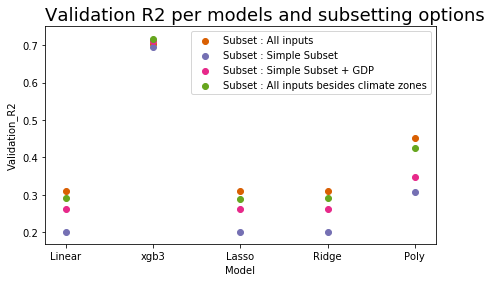

In [83]:
plot_R2_2params('Model', 'Subset', table_final,scatter=True,
                    ylim=None,title='Validation R2 per models and subsetting options',
                figsize=(7,4),color_palette='Dark2',
               savefig='All_validation_R2.png')

## Visualization functions

In [84]:
## Compare models by R2 scores

def plot_R2_2params(param_x, param_color, df,scatter=False,
                    ylim=None,title=None,figsize=(20,5),color_palette='Dark2',
                   savefig=None):

    fig, ax = plt.subplots(figsize=figsize)


    palette = plt.get_cmap(color_palette)
    num=0
    for param_color_value in df[param_color].unique():
        num+=1
        x = (df[df[param_color]==param_color_value][param_x])
        y = (df[df[param_color]==param_color_value]['Validation_R2'])
        #labels= (df[df[param_color]==learning_rate][param_color])
        if scatter == False:
            P = plt.plot(x,y, marker='.',color=palette(num), linewidth=2, alpha=0.9,
                 label=(str(param_color)+' : ' +str(param_color_value)))
        if scatter == True:
            P = plt.scatter(x,y, marker='o',color=palette(num),
                 label=(str(param_color)+' : ' +str(param_color_value)))
        
    plt.legend(loc=1, ncol=1)
    
    if title == None:
        title = "Comparing models by "+ param_x +" and "+ param_color
    plt.title(title, loc='left', fontsize=18, fontweight=0, color='black')

    plt.xlabel(param_x)
    plt.ylabel("Validation_R2")
    
    # Y lim
    if ylim != None:
        if scatter == False:
            P[0].axes.set_ylim(ylim)
        if scatter == True:
            P.axes.set_ylim(ylim)
    
    # savefig
    if savefig != None:
        plt.savefig('../ipbes_invest_crop_yield_project/output/Figures/'+savefig,dpi=500)